In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import wisps.simulations.effective_numbers as eff
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from wisps import drop_nan

In [3]:
data=eff.simulation_outputs()

In [4]:
spts=drop_nan(wispsim.simulate_spts()['spts'][0])
slprob=data['sl_prob'][4]

In [5]:
data['hs']

[100, 250, 275, 300, 325, 350, 1000]

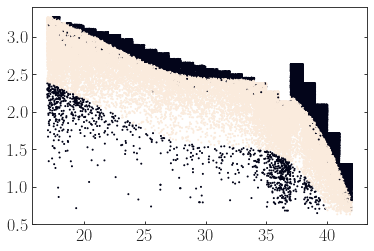

In [6]:
plt.scatter(spts, np.log10(data['dists'][4]), c=slprob, s=1. )

Text(0.5, 0, 'SpT')

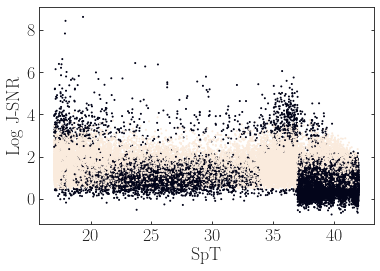

In [7]:
plt.scatter( spts, np.log10(data['snrjs'][4]),c=slprob, s=1. )
plt.ylabel('Log J-SNR', fontsize=18)
plt.xlabel('SpT', fontsize=18)